<a href="https://colab.research.google.com/github/datle1907/Predict-Pricing-House-in-HN/blob/main/Predict%20prices%20house%20in%20Ha%20Noi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong>1. Data Preparation</strong></h1>

<a id="1.1"></a>
# 1.1 Importing Necessary Libraries and datasets

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
# import test dataset
df = pd.read_csv('VN_housing_dataset.csv')
df.drop('Unnamed: 0', 1, inplace=True)
df.head(3)

,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²"
1,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²"
2,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²


<a id="1.3"></a>
## Rename column
***
Since these columns are in Vietnamese so translate into English will be more straightforward in later process. We will also analyse the column meaning:
- The `Ngày` will be the date which will contain all the day, month, year value
- The `Địa chỉ` will be the address which contains the street, ward, district, city
- The `Quận` is district
- The `Huyện` is not suppose to be the ward. However, the content they have is actually the ward
- The `Loại hình nhà ở` is a type of house which depends on the location such as villa, house in the main street, house in the alley, or townhouse.
- The `Giấy tờ pháp lý` is the legal document either already have, or on waiting, or others documents.
- The `Số tầng` is the number of floor
- The `Số phòng ngủ` is the number of bedroom
- The `Diện tích` is the area unit in meter square
- The `Dài` is the length unit in meter
- The `Rộng` is the width unit in meter
- The `Giá/m2`is the price in million VND per meter square

In [4]:
df.columns = [
    'Date', 'Address', 'District',
    'Ward', 'House_type', 'Legal_documents',
    'No_floor', 'No_bedroom', 'Area', 'Length', 'Width', 'Price']
df.head(3)

,Date,Address,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Area,Length,Width,Price
0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²"
1,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²"
2,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²


<a id="2"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong>2. Data Cleaning</strong></h1>

<a id="2.2.1"></a>
### Format date features

In [5]:
# Cast date columns to the Date data type
df['Date'] = pd.to_datetime(df['Date'])

# Create new features
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Drop original columns
df = df.drop(['Date'], axis=1)

df.head(5)

,Address,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Area,Length,Width,Price,Month,Year
0,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²",8.0,2020.0
1,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²",8.0,2020.0
2,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²,8.0,2020.0
3,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6 phòng,51 m²,12.75 m,4 m,100 triệu/m²,8.0,2020.0
4,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4 phòng,36 m²,9 m,4 m,"86,11 triệu/m²",8.0,2020.0


<a id="2.2.2"></a>
### Remove Unit for Measurement

In [6]:
# remove the unit
df['Area'] = df['Area'].replace('\sm²', '', regex=True)
df['Length'] = df['Length'].replace('\sm', '', regex=True)
df['Width'] = df['Width'].replace('\sm', '', regex=True)
df['Price'] = df['Price'].replace('\striệu/m²', '', regex=True).replace(',', '.', regex=True)

# Remove rows containing 'đ/m²' or 'tỷ/m²' in the 'Price' column
df = df[~df['Price'].astype(str).str.contains('đ/m²|tỷ/m²')]

# Reset the index of the DataFrame (optional)
df.reset_index(drop=True, inplace=True)

# df is the DataFrame, and column_list is a list of columns as strings
def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')
    return df.dtypes

# convert the value into float for all the column 'Area', 'Length', 'Width', 'Price'
coerce_df_columns_to_numeric(df, ['Area','Length', 'Width', 'Price'])

Address             object
District            object
Ward                object
House_type          object
Legal_documents     object
No_floor            object
No_bedroom          object
Area               float64
Length             float64
Width              float64
Price              float64
Month              float64
Year               float64
dtype: object

<a id="2.2.3"></a>
### Remove prefix & Typo check


In [7]:
# remove the prefix to only extract the district name
df['District'] = df['District'].replace('Quận\s', '', regex=True)
df['District'] = df['District'].replace('Huyện\s', '', regex=True)
df['District'] = df['District'].replace('Thị xã\s', '', regex=True)

# print out list of District types
print(f'Number of district: {df.District.nunique()}')
print(f'Include: {df.District.unique()}')

Number of district: 29
Include: ['Cầu Giấy' 'Thanh Xuân' 'Hai Bà Trưng' 'Tây Hồ' 'Đống Đa' 'Hà Đông'
 'Thanh Trì' 'Hoàng Mai' 'Long Biên' 'Hoàn Kiếm' 'Nam Từ Liêm' 'Ba Đình'
 'Hoài Đức' 'Bắc Từ Liêm' 'Đan Phượng' 'Thanh Oai' 'Sóc Sơn' 'Gia Lâm'
 'Chương Mỹ' 'Đông Anh' 'Thường Tín' 'Sơn Tây' 'Mê Linh' 'Thạch Thất'
 'Quốc Oai' 'Phúc Thọ' 'Phú Xuyên' 'Ba Vì' nan 'Mỹ Đức']


In [8]:
# remove the prefix to only extract the ward name
df['Ward'] = df['Ward'].replace('Phường\s', '', regex=True)
df['Ward'] = df['Ward'].replace('Xã\s', '', regex=True)
df['Ward'] = df['Ward'].replace('Thị trấn\s', '', regex=True)

# print out list of Ward types
print(f'Number of ward: {df.Ward.nunique()}')
print(f'Include: {df.Ward.unique()}')

Number of ward: 303
Include: ['Nghĩa Đô' 'Kim Giang' 'Minh Khai' 'Thụy Khuê' 'Yên Hoà' 'Trung Liệt'
 'Đống Mác' 'Xuân La' 'Văn Quán' 'Văn Điển' 'Định Công' 'Bồ Đề'
 'Quang Trung' 'Thanh Lương' 'Khương Trung' 'Phúc Tân' 'Gia Thụy'
 'Khương Đình' 'Phương Canh' 'Tương Mai' 'La Khê' 'Mễ Trì' 'Khương Mai'
 'Láng Hạ' 'Quan Hoa' 'Tây Mỗ' 'Ngọc Khánh' 'Đại Mỗ' 'Tả Thanh Oai'
 'Mỹ Đình 1' 'Tam Hiệp' 'Cống Vị' 'Bách Khoa' 'Vĩnh Phúc' 'Kim Chung'
 'Đại Kim' 'Mai Động' 'Trung Tự' 'Kiến Hưng' 'Trúc Bạch' 'Cổ Nhuế 1'
 'Đức Giang' 'Mỹ Đình 2' 'Bưởi' 'Ô Chợ Dừa' 'Long Biên' 'Hoàng Văn Thụ'
 'Mai Dịch' 'Nhân Chính' 'Vạn Phúc' 'Ngọc Hà' 'Lĩnh Nam' 'Xuân Đỉnh'
 'Phú Đô' 'Liễu Giai' 'Phùng' 'Kim Liên' 'Phúc Diễn' 'Kim Mã'
 'Trung Phụng' 'Tân Mai' 'Ngã Tư Sở' 'Trung Văn' 'Thượng Đình'
 'Hoàng Liệt' 'Thịnh Liệt' 'Quốc Tử Giám' 'Khâm Thiên' 'Trương Định'
 'Phú Diễn' 'Thạch Bàn' 'Ngọc Thụy' 'Cầu Dền' 'Phú Lương' 'Bạch Đằng'
 'Phú La' 'Hà Cầu' 'Láng Thượng' 'Phương Liệt' 'Vĩnh Hưng' 'Thanh Nhàn'
 'Cự Khối' 'Độ

In [9]:

# print out list of House_type types
print(f'Number of type house: {df.House_type.nunique()}' )
print(f'Include: {df.House_type.unique()}')

Number of type house: 4
Include: ['Nhà ngõ, hẻm' 'Nhà mặt phố, mặt tiền' 'Nhà biệt thự' 'Nhà phố liền kề'
 nan]


In [10]:
# print out list of Legal_documents types
print(f'Number of Legal_documents: {df.Legal_documents.nunique()}' )
print(f'Include: {df.Legal_documents.unique()}')

Number of Legal_documents: 3
Include: ['Đã có sổ' nan 'Đang chờ sổ' 'Giấy tờ khác']


In [11]:
# print out list of No_floor types
print(f'Number of floor: {df.No_floor.nunique()}')
print(f'Include: {df.No_floor.unique()}')

Number of floor: 28
Include: ['4' nan '6' '5' '7' '2' '3' '8' '1' '9' '50' '38' '35' '10'
 'Nhiều hơn 10' '45' '33' '42' '25' '73' '12' '65' '55' '30' '14' '40'
 '52' '32' '29']


In [12]:
df['No_bedroom'] = df['No_bedroom'].replace('\sphòng', '', regex=True)

# print out list of No_bedroom types
print(f'Number of bedroom:  {df.No_bedroom.nunique()}')
print(f'Include {df.No_bedroom.unique()}')

Number of bedroom:  11
Include ['5' '3' '4' '6' 'nhiều hơn 10' '8' '2' '7' '9' '1' '10' nan]


In [13]:
# Translate the content from Vietnamese into English

df['House_type'].replace('Nhà ngõ, hẻm', 'byroad', inplace=True)
df['House_type'].replace('Nhà mặt phố, mặt tiền', 'street_house', inplace=True)
df['House_type'].replace('Nhà biệt thự', 'villa', inplace=True)
df['House_type'].replace('Nhà phố liền kề', 'townhouse', inplace=True)

df['Legal_documents'].replace('Đã có sổ', 'available', inplace=True)
df['Legal_documents'].replace('Đang chờ sổ', 'waiting', inplace=True)
df['Legal_documents'].replace('Giấy tờ khác', 'others', inplace=True)

df['No_floor'].replace('Nhiều hơn 10', 'greater_than_10', inplace=True)

df['No_bedroom'].replace('nhiều hơn 10', 'greater_than_10', inplace=True)

df.head(3)

,Address,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Area,Length,Width,Price,Month,Year
0,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Cầu Giấy,Nghĩa Đô,byroad,available,4,5,46.0,NaN,NaN,86.96,8.0,2020.0
1,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Thanh Xuân,Kim Giang,street_house,NaN,NaN,3,37.0,NaN,NaN,116.22,8.0,2020.0
2,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Hai Bà Trưng,Minh Khai,byroad,available,4,4,40.0,10.0,4.0,65.00,8.0,2020.0


<a id="2.4"></a>
### Upper Case the content


In [14]:
# Cast all values inside the dataframe (except the columns' name) into upper case.
df = df.applymap(lambda s: s.upper() if type(s) == str else s)
df.head(3)

,Address,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Area,Length,Width,Price,Month,Year
0,"ĐƯỜNG HOÀNG QUỐC VIỆT, PHƯỜNG NGHĨA ĐÔ, QUẬN C...",CẦU GIẤY,NGHĨA ĐÔ,BYROAD,AVAILABLE,4,5,46.0,NaN,NaN,86.96,8.0,2020.0
1,"ĐƯỜNG KIM GIANG, PHƯỜNG KIM GIANG, QUẬN THANH ...",THANH XUÂN,KIM GIANG,STREET_HOUSE,NaN,NaN,3,37.0,NaN,NaN,116.22,8.0,2020.0
2,"PHỐ MINH KHAI, PHƯỜNG MINH KHAI, QUẬN HAI BÀ T...",HAI BÀ TRƯNG,MINH KHAI,BYROAD,AVAILABLE,4,4,40.0,10.0,4.0,65.00,8.0,2020.0


<a id="2.5"></a>
## Missing values


In [15]:
df.isna().sum().sort_values(ascending = False)

Length             62065
Width              46632
No_floor           45584
Legal_documents    28632
Ward                  41
No_bedroom            39
Address               36
House_type            30
Price                 13
District               2
Area                   2
Month                  1
Year                   1
dtype: int64

<br><br>
<a id="2.6"></a>
## Check data types

In [16]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81639 entries, 0 to 81638
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Address          81603 non-null  object 
 1   District         81637 non-null  object 
 2   Ward             81598 non-null  object 
 3   House_type       81609 non-null  object 
 4   Legal_documents  53007 non-null  object 
 5   No_floor         36055 non-null  object 
 6   No_bedroom       81600 non-null  object 
 7   Area             81637 non-null  float64
 8   Length           19574 non-null  float64
 9   Width            35007 non-null  float64
 10  Price            81626 non-null  float64
 11  Month            81638 non-null  float64
 12  Year             81638 non-null  float64
dtypes: float64(6), object(7)
memory usage: 8.1+ MB


In [17]:
df[['Month', 'Year']] = df[['Month', 'Year']].astype('int64', errors='ignore')
df['No_floor'] = df['No_floor'].astype('int64', errors='ignore')
df['No_bedroom'] = df['No_bedroom'].astype('int64', errors='ignore')

In [18]:
# check the unique value of the month
df['Month'].value_counts(dropna=False)

7.0     44384
6.0     29434
8.0      7472
5.0       192
4.0        57
3.0        51
2.0        36
10.0        6
12.0        3
11.0        2
9.0         1
NaN         1
Name: Month, dtype: int64

In [19]:
# check the unique value of the year
df['Year'].value_counts(dropna=False)

2020.0    81620
2019.0       18
NaN           1
Name: Year, dtype: int64

In [20]:
# check the unique value of legal_documents to to see if the value is completely translated
df['Legal_documents'].value_counts(dropna=False)

AVAILABLE    52330
NaN          28632
WAITING        343
OTHERS         334
Name: Legal_documents, dtype: int64

In [21]:
# fill the missing value for Legal_documents by 'OTHERS'
df['Legal_documents'].fillna("OTHERS", inplace=True)

In [22]:
# check the unique value of the House_type
df['House_type'].value_counts(dropna=False)

BYROAD          61971
STREET_HOUSE    16876
TOWNHOUSE        1841
VILLA             921
NaN                30
Name: House_type, dtype: int64

In [23]:
# fill the missing value with mode
mode = df['House_type'].mode()[0]
df['House_type'].fillna(mode, inplace=True)

In [24]:
# check if there is any missing value in ward
df[['Address', 'Ward', 'District']][df['Ward'].isna()]

,Address,Ward,District
321,"ĐƯỜNG AN DƯƠNG VƯƠNG, QUẬN TÂY HỒ, HÀ NỘI",NaN,TÂY HỒ
735,"CẦU KHÊ TANG, QUẬN HÀ ĐÔNG, HÀ NỘI",NaN,HÀ ĐÔNG
4516,NaN,NaN,HOÀI ĐỨC
5245,NaN,NaN,LONG BIÊN
7098,NaN,NaN,THANH TRÌ
8508,NaN,NaN,THANH XUÂN
12488,NaN,NaN,HÀ ĐÔNG
14426,NaN,NaN,HÀ ĐÔNG
14931,NaN,NaN,HOÀNG MAI
21030,NaN,NaN,BẮC TỪ LIÊM


In [25]:
# fill the missing value with None for Ward and Address column
df['Ward'].fillna("None", inplace=True)
df['Address'].fillna("None", inplace=True)

# check the unique value of the No_floor
df['No_floor'].value_counts(dropna=False)

NaN                45584
5                  15611
4                  12174
3                   3592
6                   2095
2                   1017
1                    626
7                    592
8                    186
9                     87
10                    36
45                     8
GREATER_THAN_10        7
35                     6
38                     2
50                     2
12                     2
33                     1
42                     1
25                     1
73                     1
65                     1
55                     1
30                     1
14                     1
40                     1
52                     1
32                     1
29                     1
Name: No_floor, dtype: int64

In [26]:
# fill the missing value with mode
mode = df['No_floor'].mode()[0]
df['No_floor'].fillna(mode, inplace=True)

In [27]:
# define a function to feed into the lambda
def No_floor_count(value):
    if value == '1' or value == '2' or value == '3' \
            or value == '4' or value == '5' or value == '6' \
            or value == '7' or value == '8' or value == '9' or value == '10':
        return value
    else:
        return 'GREATER_THAN_10'

# make any floor greater than 10 to be in category 'GREATER_THAN_10'
df['No_floor'] = df['No_floor'].map(lambda n: No_floor_count(n))
# check if the above operation is success or not
df['No_floor'].value_counts(dropna=False)

5                  61195
4                  12174
3                   3592
6                   2095
2                   1017
1                    626
7                    592
8                    186
9                     87
GREATER_THAN_10       39
10                    36
Name: No_floor, dtype: int64

In [28]:
# check the No_bedroom
df['No_bedroom'].value_counts(dropna=False)

4                  28771
3                  26899
5                   7828
2                   7279
6                   6390
1                   1361
8                    921
GREATER_THAN_10      853
7                    670
10                   350
9                    278
NaN                   39
Name: No_bedroom, dtype: int64

In [29]:
# fill the missing value with mode
mode = df['No_bedroom'].mode()[0]
df['No_bedroom'].fillna(mode, inplace=True)

In [30]:
# Fill the missing value of area base on the median of area in district
df['Area'] = df.groupby('District')['Area'].apply(lambda x: x.fillna(x.median()))

# fill the missing value of price base on the median of price in district
df['Price'] = df.groupby('District')['Price'].apply(lambda x: x.fillna(x.median()))

# fill the missing value of length base on the median of length of area
df['Length'] = df.groupby('Area')['Length'].apply(lambda x: x.fillna(x.median()))

# fill the remaining missing value base on the mean of the entire column
df['Length'].fillna(df['Length'].mean(), inplace=True)

# fill the missing value of width base on the median of width of area
df['Width'] = df.groupby('Area')['Width'].apply(lambda x: x.fillna(x.median()))

# fill the remaining missing value base on the mean of the entire column
df['Width'].fillna(df['Width'].mean(), inplace=True)

In [31]:
df.dropna(subset = ['District','Area','Price','Month', 'Year'], inplace = True)

In [32]:
df.isna().sum()

Address            0
District           0
Ward               0
House_type         0
Legal_documents    0
No_floor           0
No_bedroom         0
Area               0
Length             0
Width              0
Price              0
Month              0
Year               0
dtype: int64

### Let's first identify features with single or unique value in Adress field like `HÀ NỘI`, `PHƯỜNG`, `HUYỆN`, and `QUẬN`
since they will be less significant so we can drop them.

In [33]:
# get the remaing of the string (street number and street name) and put into new column call street
df['Street'] = df['Address'].str.replace('(, QUẬN|, PHƯỜNG|, HUYỆN|, HÀ NỘI).*', '', regex=True)
# remove all the prefix in the street
df['Street'] = df['Street'].str.replace('ĐƯỜNG\s', '', regex=True)
# remove all the prefix in the street
df['Street'] = df['Street'].str.replace('PHỐ\s', '', regex=True)

print(f'Number of street: {df.Street.nunique()}')
print(f'Include: {df.Street.unique()}')

Number of street: 7273
Include: ['HOÀNG QUỐC VIỆT' 'KIM GIANG' 'MINH KHAI' ... 'LÊ TRỌNG TẤN HOÀI ĐỨC'
 'LẠC LONG QUÂN TÂY HỒ' 'SỐ 7 ĐẠI LỘ THĂNG LONG NAM TỪ LIÊM']


In [34]:
# since the column street, ward, and district already present the column address we delete the column address
df.drop('Address', axis = 1, inplace=True)

In [35]:
# see the unique value of column year
df['Year'].value_counts()

2020.0    81619
2019.0       18
Name: Year, dtype: int64

In [36]:
# drop all the row with value of 2019
df.drop(df.loc[df['Year']==2019].index, inplace=True)
# check if the above operation is successful or not
df['Year'].value_counts()

2020.0    81619
Name: Year, dtype: int64

In [37]:
# drop the column year because it is not meaningful anymore
df.drop('Year', 1, inplace=True)
# check the missing value
df.isna().sum()

District           0
Ward               0
House_type         0
Legal_documents    0
No_floor           0
No_bedroom         0
Area               0
Length             0
Width              0
Price              0
Month              0
Street             0
dtype: int64

In [38]:
# print all the info
print("Number of duplicated records in df: ", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates in df:", len(df.index))


Number of duplicated records in df:  3344
Number of rows after drop of duplicates in df: 78275


<Axes: >

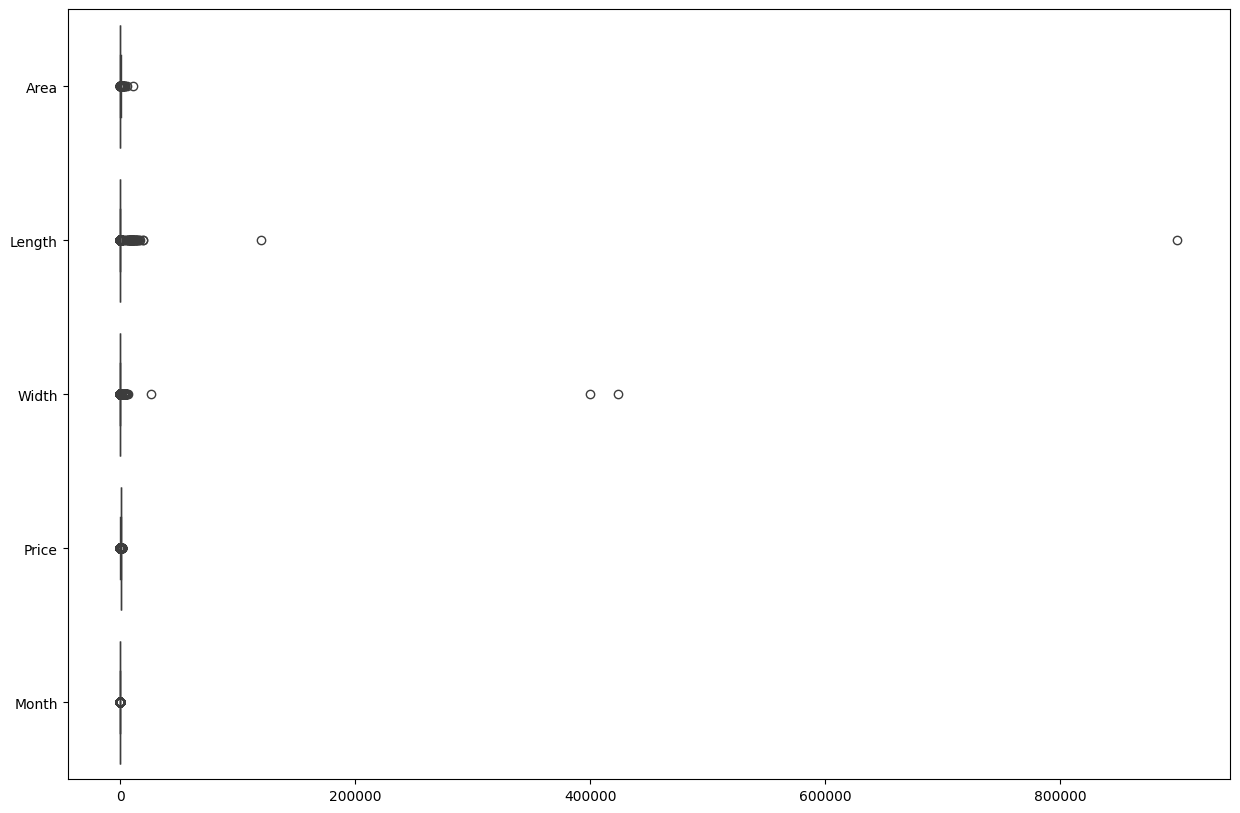

In [39]:
# plot the boxplot to see the outlier of each numerical column
plt.figure(figsize= (15,10))
sns.boxplot(data=df,orient="h")

For all numerical columns, I see some extreme outlier values in `Area`,`Length`, and `Width`

# Outlier detection using boxplot

<Axes: >

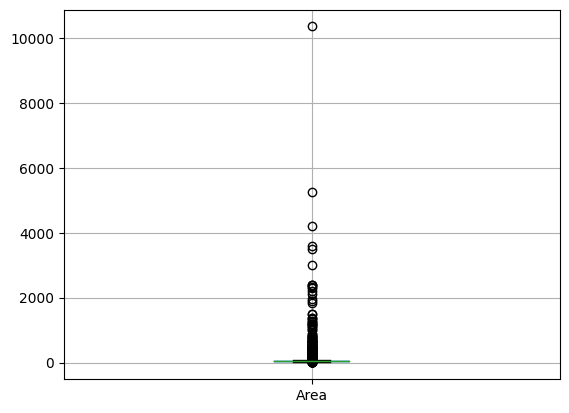

In [40]:
# plot the boxplot to see the outlier
df.boxplot('Area')

In [41]:
# replace all the value greater than 20000 with the mean of the column
df.loc[df['Area'] > 20000, 'Area'] = df['Area'].mean()

<Axes: >

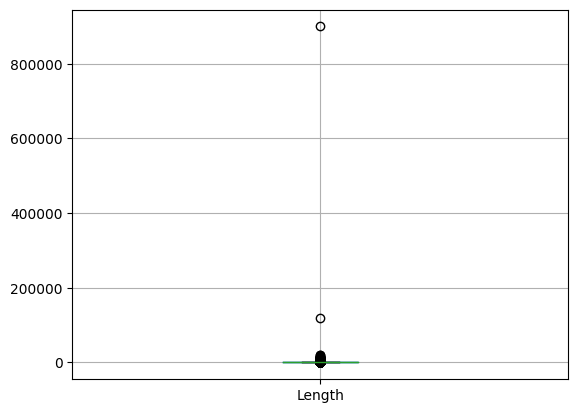

In [42]:
# plot the boxplot to see the outlier
df.boxplot('Length')

In [43]:
# replace all the value greater than 200000 with the mean of the column
df.loc[df['Length'] > 200000, 'Length'] = df['Length'].mean()

<Axes: >

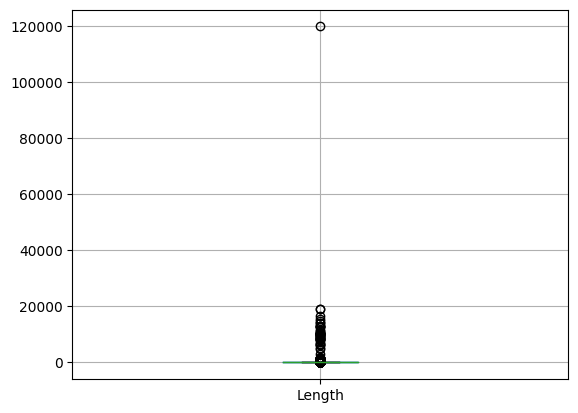

In [44]:
# plot the boxplot to see the outlier
df.boxplot('Length')

In [45]:
# replace all the value greater than 20000 with the mean of the column
df.loc[df['Length'] > 20000, 'Length'] = df['Length'].mean()

<Axes: >

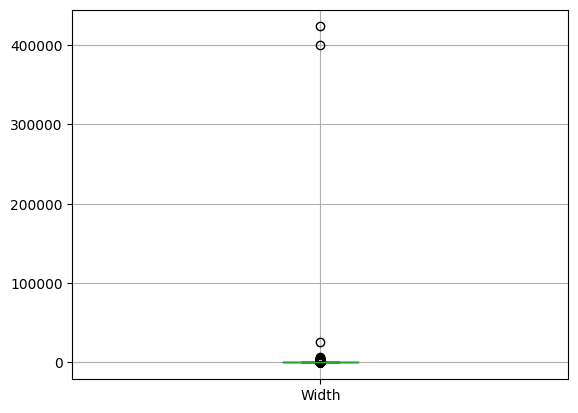

In [46]:
# plot the boxplot to see the outlier
df.boxplot('Width')

In [47]:
# replace all the value greater than 100000 with the mean of the column
df.loc[df['Width'] > 100000, 'Width'] = df['Width'].mean()

<Axes: >

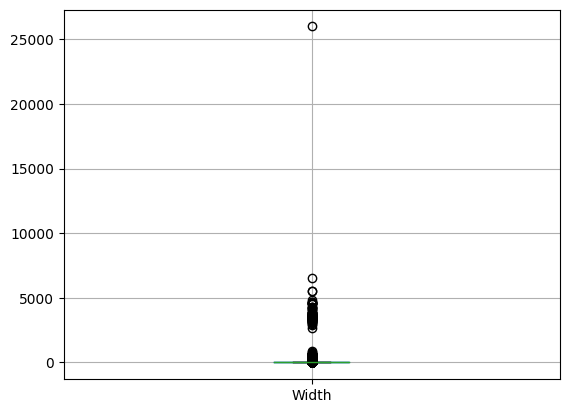

In [48]:
# plot the boxplot to see the outlier
df.boxplot('Width')

In [49]:
# replace all the value greater than 10000 with the mean of the column
df.loc[df['Width'] > 10000, 'Width'] = df['Width'].mean()

<a id="2.9.4"></a>
# Remove Impossible Values





### Area cannot be larger than Length * Width

In [50]:
def checkArea(df):
    #in case area is smaller or equal to the length * width -> it is correct -> return True otherwise -> return false
    if df['Length'] * df['Width'] >= df['Area']:
        return True
    return False

df['correctArea'] = df.apply(lambda r: checkArea(r), axis=1) # axis = 1 is for columns

In [51]:
#Determining the number of impossible values for Area
df1 = df[(df['correctArea'] == False)]
df1

,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Area,Length,Width,Price,Month,Street,correctArea
0,CẦU GIẤY,NGHĨA ĐÔ,BYROAD,AVAILABLE,4,5,46.0,11.0,4.0,86.96,8.0,HOÀNG QUỐC VIỆT,False
5,CẦU GIẤY,YÊN HOÀ,BYROAD,AVAILABLE,5,GREATER_THAN_10,46.0,12.1,3.8,104.35,8.0,YÊN HÒA,False
9,HÀ ĐÔNG,VĂN QUÁN,BYROAD,AVAILABLE,4,3,41.0,10.0,3.5,64.63,8.0,19/5,False
15,LONG BIÊN,BỒ ĐỀ,BYROAD,AVAILABLE,5,4,52.0,12.0,4.2,93.27,8.0,BỒ ĐỀ,False
17,HOÀN KIẾM,PHÚC TÂN,STREET_HOUSE,AVAILABLE,7,GREATER_THAN_10,165.0,18.5,5.0,103.03,8.0,PHÚC TÂN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81611,THANH XUÂN,PHƯƠNG LIỆT,STREET_HOUSE,AVAILABLE,5,4,45.0,11.0,4.0,88.89,2.0,NGUYỄN LÂN,False
81612,HOÀNG MAI,ĐỊNH CÔNG,BYROAD,AVAILABLE,5,6,45.0,11.0,4.0,96.67,2.0,ĐỊNH CÔNG THƯỢNG,False
81613,ĐỐNG ĐA,NAM ĐỒNG,TOWNHOUSE,AVAILABLE,5,6,50.0,11.0,4.0,290.00,2.0,HÀO NAM,False
81614,THANH XUÂN,KHƯƠNG ĐÌNH,TOWNHOUSE,AVAILABLE,4,4,42.0,10.0,4.0,71.43,2.0,BÙI XƯƠNG TRẠCH,False


In [52]:
#Drop Area column
df.drop(columns=['correctArea', 'Area'], inplace = True)

#Recalculate :
def calArea(df):
    return df['Length'] * df['Width']

df['Area'] = df.apply(lambda r: calArea(r), axis=1) # axis = 1 is for columns

### Length and Width cannot be lower than 2.5 meter square

In [53]:
lw_df = df[(df['Width'] < 2.5) | (df['Length'] < 2.5)]
print(len(lw_df))
lw_df.head(3)

134


,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Length,Width,Price,Month,Street,Area
1441,HAI BÀ TRƯNG,THANH NHÀN,BYROAD,AVAILABLE,2,1,6.75,2.0,66.67,8.0,BẠCH MAI,13.5
3080,HOÀNG MAI,HOÀNG VĂN THỤ,STREET_HOUSE,OTHERS,5,3,2.00,1.0,161.67,8.0,HOÀNG MAI,2.0
5096,ĐỐNG ĐA,KHÂM THIÊN,BYROAD,AVAILABLE,4,2,110.00,2.1,81.82,8.0,NGÕ KHÂM THIÊN,231.0


In [54]:
#since the data point of the impossible Area values is small so that set those values lower than 2.5 back to 2.5
df.loc[(df['Width'] < 2.5), 'Width'] = 2.5
df.loc[(df['Length'] < 2.5), 'Length'] = 2.5

### Area cannot be lower than 20 metersquare.
****
According to the Government, in order to be sold successfully the Area cannot lower than 20 metersquare if it is lower than 20 then it must have the legal document available otherwise, it cannot be sold

In [55]:
#Selecting the plots do not have or waiting legal document
legal_document = ['WAITING', 'OTHERS']

#query the plots have values Area is lower than 20 and do not have available legal documents
lw_df = df[(df['Area'] < 20) & (df['Legal_documents'].isin(legal_document))]
print(len(lw_df))
lw_df

475


,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Length,Width,Price,Month,Street,Area
386,HAI BÀ TRƯNG,TRƯƠNG ĐỊNH,BYROAD,OTHERS,5,2,5.0,3.0,162.50,8.0,TRƯƠNG ĐỊNH,15.0
477,NAM TỪ LIÊM,TRUNG VĂN,BYROAD,OTHERS,5,3,4.3,3.0,203.85,8.0,TRUNG VĂN,12.9
692,HÀ ĐÔNG,MỘ LAO,BYROAD,OTHERS,5,2,6.0,3.0,60.98,8.0,"1, TRẦN PHÚ",18.0
1225,BA ĐÌNH,NGỌC KHÁNH,BYROAD,OTHERS,5,3,6.0,3.0,69.44,8.0,NÚI TRÚC,18.0
1423,ĐỐNG ĐA,Ô CHỢ DỪA,STREET_HOUSE,OTHERS,5,2,5.0,3.0,340.00,8.0,Ô CHỢ DỪA,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
80960,HAI BÀ TRƯNG,QUỲNH MAI,BYROAD,OTHERS,5,2,5.0,3.0,107.14,6.0,8/3,15.0
81294,ĐỐNG ĐA,HÀNG BỘT,BYROAD,OTHERS,5,3,5.0,3.0,76.67,5.0,THỊNH HÀO 3,15.0
81390,HOÀNG MAI,TRẦN PHÚ,BYROAD,OTHERS,5,2,6.0,3.2,60.00,5.0,KHUYẾN LƯƠNG,19.2
81587,HAI BÀ TRƯNG,BẠCH MAI,TOWNHOUSE,OTHERS,5,3,6.0,3.2,83.33,2.0,BẠCH MAI,19.2


In [56]:
#since the data point of the impossible Area values is small so that set those values lower than 20 back to 20
df.loc[((df['Area'] < 20) & (df['Legal_documents'].isin(legal_document))), 'Area'] = 20

<a id="2.10"></a>
# Create categorical price


### Price of each house type

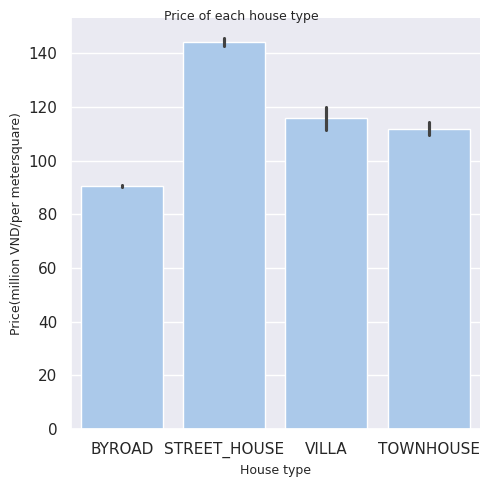

In [57]:
sns.set_theme(palette="pastel") #choose pastel color

plot = sns.catplot(data=df, kind="bar", x="House_type", y="Price", height = 5)

plot.fig.suptitle("Price of each house type", fontsize=9)
plot.set_xlabels("House type", fontsize = 9)
plot.set_ylabels("Price(million VND/per metersquare)", fontsize = 9)


## New "Region" Column
***
+ The target is to find the location for the best optimised region.
+ Hence, at first the dataset is separted into `Urban` or `Suburbans`, then compare them.

In [58]:
def region(district):
    urban = ['CẦU GIẤY', 'THANH XUÂN', 'HAI BÀ TRƯNG', 'TÂY HỒ', 'ĐỐNG ĐA', 'HOÀNG MAI', 'HOÀN KIẾM',  'BA ĐÌNH']
    location = 'SUBURBAN'
    for i in range (0, 8):
        if(district == urban[i]): location = 'URBAN'
    return location

df['Region'] = df['District'].apply(region)

In [59]:
df.head(3)

,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Length,Width,Price,Month,Street,Area,Region
0,CẦU GIẤY,NGHĨA ĐÔ,BYROAD,AVAILABLE,4,5,11.0,4.0,86.96,8.0,HOÀNG QUỐC VIỆT,44.0,URBAN
1,THANH XUÂN,KIM GIANG,STREET_HOUSE,OTHERS,5,3,10.0,4.0,116.22,8.0,KIM GIANG,40.0,URBAN
2,HAI BÀ TRƯNG,MINH KHAI,BYROAD,AVAILABLE,4,4,10.0,4.0,65.00,8.0,MINH KHAI,40.0,URBAN


<a id="3.2"></a>
# Determine Location (urban and suburban) influence the price
### Distribution (Proportion) of Urban and Suburban

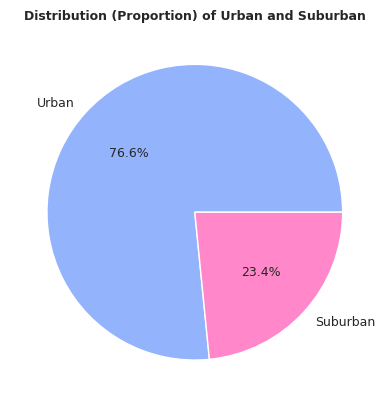

In [60]:
# Pie chart Distribution (Proportion) of Urban and Suburban
labels = ['Urban', 'Suburban']
#colors
colors = ['#94B3FD', '#FF87CA']
ax = plt.pie(df['Region'].value_counts(), labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 9});
plt.title('Distribution (Proportion) of Urban and Suburban', fontsize=9, fontweight = 'bold')
plt.show()

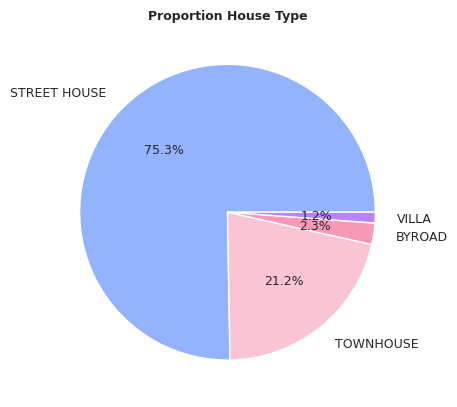

In [61]:
# Pie chart
labels = ['STREET HOUSE', 'TOWNHOUSE', 'BYROAD', 'VILLA']
#colors
colors = ['#94B3FD', '#F9C5D5', '#F999B7', '#B983FF']
ax = plt.pie(df['House_type'].value_counts(), labels=labels, labeldistance=1.15, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 9});
plt.title('Proportion House Type', fontsize=9, fontweight = 'bold')
plt.show()

# Feature Engineering

<a id="4"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong>4. Feature Engineering</strong></h1>

In [62]:
df['Region'] = np.where(df.Region == 'URBAN', 0, 1)

In [63]:
df.head(3)

,District,Ward,House_type,Legal_documents,No_floor,No_bedroom,Length,Width,Price,Month,Street,Area,Region
0,CẦU GIẤY,NGHĨA ĐÔ,BYROAD,AVAILABLE,4,5,11.0,4.0,86.96,8.0,HOÀNG QUỐC VIỆT,44.0,0
1,THANH XUÂN,KIM GIANG,STREET_HOUSE,OTHERS,5,3,10.0,4.0,116.22,8.0,KIM GIANG,40.0,0
2,HAI BÀ TRƯNG,MINH KHAI,BYROAD,AVAILABLE,4,4,10.0,4.0,65.00,8.0,MINH KHAI,40.0,0


### Encode categorical features

In [64]:
def to_label_encoder(df, column, category):
    oe = OrdinalEncoder(categories=[category])
    # get the column and encoding it into dataframe.
    data = oe.fit_transform(df[[column]])
    # create the dataframe base on data and the value will be integer.
    encode_df = pd.DataFrame(data=data, columns=[column], dtype=int)
    # add the encoding dataframe back to the dataframe.
    df[column] = encode_df.values



In [65]:
lst_No_bedroom = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'GREATER_THAN_10']
lst_Legal_documents = ['AVAILABLE','WAITING', 'OTHERS']

to_label_encoder(df, 'No_bedroom', lst_No_bedroom)
to_label_encoder(df, 'No_floor', lst_No_bedroom)
to_label_encoder(df, 'Legal_documents', lst_Legal_documents)

In [66]:
def to_one_hot_encoder(df, column_name):
    ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='if_binary')
    data = ohe.fit_transform(df[[column_name]])
    # Get the feature names using get_feature_names_out
    feature_names = ohe.get_feature_names_out([column_name])
    # Create the encoding DataFrame with feature names and integer values
    encode_df = pd.DataFrame(data=data, columns=feature_names, dtype=int)
    # Add the encoding DataFrame back to the original DataFrame
    df.reset_index(inplace=True, drop=True)
    df = pd.concat([df, encode_df], axis=1)
    # Remove the original column
    df.drop([column_name], inplace=True, axis=1)
    return df

In [67]:
df = to_one_hot_encoder(df, 'District')
df = to_one_hot_encoder(df, 'Ward')
df = to_one_hot_encoder(df, 'House_type')

In [68]:
df.head(5)

,Legal_documents,No_floor,No_bedroom,Length,Width,Price,Month,Street,Area,Region,...,Ward_ĐỒNG XUÂN,Ward_ĐỖ ĐỘNG,Ward_ĐỘI CẤN,Ward_ĐỨC GIANG,Ward_ĐỨC THƯỢNG,Ward_ĐỨC THẮNG,House_type_BYROAD,House_type_STREET_HOUSE,House_type_TOWNHOUSE,House_type_VILLA
0,0,3,4,11.00,4.0,86.96,8.0,HOÀNG QUỐC VIỆT,44.0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,4,2,10.00,4.0,116.22,8.0,KIM GIANG,40.0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,3,3,10.00,4.0,65.00,8.0,MINH KHAI,40.0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,4,5,12.75,4.0,100.00,8.0,VÕNG THỊ,51.0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,4,3,9.00,4.0,86.11,8.0,KIM GIANG,36.0,0,...,0,0,0,0,0,0,1,0,0,0


<a id="5"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong>5. Model Building</strong></h1>


<a id="5.1"></a>
# Train/Test split
Separating the data into train and test involves randomness.

In [69]:
X = df.drop(['Price','Street'], axis=1) # predictive variables
y = df['Price']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [70]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
import optuna
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Define the objective function for hyperparameter optimization
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42
    }

    model = lgb.LGBMRegressor(**param)

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a study and optimize hyperparameters with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Print the best parameters and their R^2 score
best_params = study.best_params
best_score = study.best_value
print(f"Best Parameters: {best_params}")
print(f"Best R^2 Score: {best_score}")

[I 2024-03-31 15:16:54,701] A new study created in memory with name: no-name-3d4e38e5-44ef-47df-9853-7085d44a3cba


[LightGBM] [Warning] lambda_l2 is set with lambda=0.9407118208735633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9407118208735633
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.9407118208735633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9407118208735633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=0.9407118208735633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9407118208735633
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 102.

[I 2024-03-31 15:16:56,979] Trial 0 finished with value: 0.3813834312257276 and parameters: {'lambda': 0.9407118208735633, 'alpha': 0.15775302998538715, 'learning_rate': 0.08904013945771047, 'colsample_bytree': 0.7890761752924824, 'min_child_weight': 7, 'max_depth': 4, 'subsample': 0.5173108861338517}. Best is trial 0 with value: 0.3813834312257276.


[LightGBM] [Warning] lambda_l2 is set with lambda=0.00013645332840613242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013645332840613242
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.00013645332840613242, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013645332840613242
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=0.0001364533

[I 2024-03-31 15:16:58,901] Trial 1 finished with value: 0.38861892980278046 and parameters: {'lambda': 0.00013645332840613242, 'alpha': 0.0013520061812696536, 'learning_rate': 0.03743205178882593, 'colsample_bytree': 0.5944422522580466, 'min_child_weight': 4, 'max_depth': 8, 'subsample': 0.7700638943186128}. Best is trial 1 with value: 0.38861892980278046.


[LightGBM] [Warning] lambda_l2 is set with lambda=8.699347063965253e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.699347063965253e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=8.699347063965253e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.699347063965253e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=8.69934706396525

[I 2024-03-31 15:17:00,309] Trial 2 finished with value: 0.40198941052469883 and parameters: {'lambda': 8.699347063965253e-06, 'alpha': 5.282602166884601e-07, 'learning_rate': 0.05959515756625457, 'colsample_bytree': 0.34323642843305613, 'min_child_weight': 9, 'max_depth': 10, 'subsample': 0.7560722713116288}. Best is trial 2 with value: 0.40198941052469883.


[LightGBM] [Warning] lambda_l2 is set with lambda=0.00033449204074776793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033449204074776793
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.00033449204074776793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033449204074776793
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=0.0003344920

[I 2024-03-31 15:17:01,828] Trial 3 finished with value: 0.370323782343861 and parameters: {'lambda': 0.00033449204074776793, 'alpha': 0.026555810627128543, 'learning_rate': 0.02510362738464156, 'colsample_bytree': 0.7398329760769131, 'min_child_weight': 2, 'max_depth': 8, 'subsample': 0.7271339443079001}. Best is trial 2 with value: 0.40198941052469883.


[LightGBM] [Warning] lambda_l2 is set with lambda=0.00033449204074776793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033449204074776793
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=0.021355764815839944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021355764815839944
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.021355764815839944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021355764815839944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lam

[I 2024-03-31 15:17:03,217] Trial 4 finished with value: 0.3435306000567976 and parameters: {'lambda': 0.021355764815839944, 'alpha': 0.013202516124892334, 'learning_rate': 0.05253765516715717, 'colsample_bytree': 0.7638395629482959, 'min_child_weight': 4, 'max_depth': 3, 'subsample': 0.7521959152289527}. Best is trial 2 with value: 0.40198941052469883.


[LightGBM] [Warning] lambda_l2 is set with lambda=2.6752160977952597e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6752160977952597e-05
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=2.6752160977952597e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6752160977952597e-05
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=2.6752160977

[I 2024-03-31 15:17:05,144] Trial 5 finished with value: 0.40688303436723916 and parameters: {'lambda': 2.6752160977952597e-05, 'alpha': 4.943146048841706e-06, 'learning_rate': 0.08226866109793245, 'colsample_bytree': 0.5356280893717156, 'min_child_weight': 10, 'max_depth': 9, 'subsample': 0.8080364922953668}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] lambda_l2 is set with lambda=2.6752160977952597e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6752160977952597e-05
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=5.935098562611898e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.935098562611898e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=5.935098562611898e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.935098562611898e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

[I 2024-03-31 15:17:06,721] Trial 6 finished with value: 0.3974485077392199 and parameters: {'lambda': 5.935098562611898e-07, 'alpha': 1.7991103378802353e-06, 'learning_rate': 0.045159768651945605, 'colsample_bytree': 0.49467651278774316, 'min_child_weight': 5, 'max_depth': 10, 'subsample': 0.9404760736230646}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] lambda_l2 is set with lambda=5.935098562611898e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.935098562611898e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=2.842771631091524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.842771631091524e-05
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=2.842771631091524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.842771631091524e-05
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[I 2024-03-31 15:17:08,154] Trial 7 finished with value: 0.3825994885500029 and parameters: {'lambda': 2.842771631091524e-05, 'alpha': 1.6972606077641893e-05, 'learning_rate': 0.05730754350011596, 'colsample_bytree': 0.5502387883738071, 'min_child_weight': 2, 'max_depth': 5, 'subsample': 0.8544728594640706}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] lambda_l2 is set with lambda=0.001801893578310697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001801893578310697
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.001801893578310697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001801893578310697
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=0.001801893578310697

[I 2024-03-31 15:17:09,446] Trial 8 finished with value: 0.40094463917199274 and parameters: {'lambda': 0.001801893578310697, 'alpha': 0.2858173126366177, 'learning_rate': 0.09626747628563101, 'colsample_bytree': 0.6866848611731851, 'min_child_weight': 2, 'max_depth': 6, 'subsample': 0.791409305828417}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with lambda=0.001801893578310697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001801893578310697
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=2.2001740265150004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2001740265150004e-06
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=2.2001740265150004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2001740265150004e-06
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

[I 2024-03-31 15:17:10,541] Trial 9 finished with value: 0.35122407722222615 and parameters: {'lambda': 2.2001740265150004e-06, 'alpha': 6.824093369749258e-05, 'learning_rate': 0.06264619673912494, 'colsample_bytree': 0.5302394886703717, 'min_child_weight': 3, 'max_depth': 3, 'subsample': 0.7929629092540084}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with lambda=2.2001740265150004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2001740265150004e-06
[LightGBM] [Warning] lambda_l2 is set with lambda=1.8469635112845252e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8469635112845252e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 i

[I 2024-03-31 15:17:12,121] Trial 10 finished with value: 0.40375755707634176 and parameters: {'lambda': 1.8469635112845252e-08, 'alpha': 3.119872059569838e-08, 'learning_rate': 0.07791347801680717, 'colsample_bytree': 0.8893998715611434, 'min_child_weight': 10, 'max_depth': 8, 'subsample': 0.6332061588086129}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] lambda_l2 is set with lambda=1.8469635112845252e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8469635112845252e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=2.1330630000828457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1330630000828457e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=2.1330630000828457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1330630000828457e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

[I 2024-03-31 15:17:13,569] Trial 11 finished with value: 0.4055106493869931 and parameters: {'lambda': 2.1330630000828457e-08, 'alpha': 2.53687017872951e-08, 'learning_rate': 0.07955269507874066, 'colsample_bytree': 0.8836497681759093, 'min_child_weight': 10, 'max_depth': 8, 'subsample': 0.6224133930787513}. Best is trial 5 with value: 0.40688303436723916.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l2 is set with lambda=2.1330630000828457e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1330630000828457e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=1.028374641845859e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.028374641845859e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.028374641845859e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.028374641845859e-08
[LightGBM] [Warning] Accuracy may be bad since you d

[I 2024-03-31 15:17:15,021] Trial 12 finished with value: 0.4074271111479274 and parameters: {'lambda': 1.028374641845859e-08, 'alpha': 1.2641277189010314e-08, 'learning_rate': 0.07588878404171744, 'colsample_bytree': 0.41121873566074285, 'min_child_weight': 8, 'max_depth': 9, 'subsample': 0.6004876245954818}. Best is trial 12 with value: 0.4074271111479274.


[LightGBM] [Warning] lambda_l2 is set with lambda=6.59603347278341e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.59603347278341e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=6.59603347278341e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.59603347278341e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=6.59603347278341e-07

[I 2024-03-31 15:17:17,049] Trial 13 finished with value: 0.40597107913909225 and parameters: {'lambda': 6.59603347278341e-07, 'alpha': 5.500599665399823e-07, 'learning_rate': 0.0743030339510558, 'colsample_bytree': 0.4052696139115368, 'min_child_weight': 8, 'max_depth': 9, 'subsample': 0.5085214274212889}. Best is trial 12 with value: 0.4074271111479274.


[LightGBM] [Warning] lambda_l2 is set with lambda=6.59603347278341e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.59603347278341e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=7.78651550786229e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78651550786229e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=7.78651550786229e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.78651550786229e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-03-31 15:17:18,655] Trial 14 finished with value: 0.4019292094514426 and parameters: {'lambda': 7.78651550786229e-08, 'alpha': 1.0176146376147786e-05, 'learning_rate': 0.07038929234347972, 'colsample_bytree': 0.4544747562033957, 'min_child_weight': 7, 'max_depth': 7, 'subsample': 0.6467920472735557}. Best is trial 12 with value: 0.4074271111479274.


[LightGBM] [Warning] lambda_l2 is set with lambda=0.009224720411928443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009224720411928443
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.009224720411928443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009224720411928443
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=0.009224720411928443

[I 2024-03-31 15:17:20,293] Trial 15 finished with value: 0.23709415007719548 and parameters: {'lambda': 0.009224720411928443, 'alpha': 1.0821945476478425e-08, 'learning_rate': 0.010218736747508464, 'colsample_bytree': 0.32586875728789766, 'min_child_weight': 8, 'max_depth': 9, 'subsample': 0.8955926296380264}. Best is trial 12 with value: 0.4074271111479274.


[LightGBM] [Warning] lambda_l2 is set with lambda=0.6572939301130846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6572939301130846
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=0.6572939301130846, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6572939301130846
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=0.6572939301130846, reg_lamb

[I 2024-03-31 15:17:21,818] Trial 16 finished with value: 0.39950516941800807 and parameters: {'lambda': 0.6572939301130846, 'alpha': 0.000790412990606147, 'learning_rate': 0.089675089892054, 'colsample_bytree': 0.41297055499788704, 'min_child_weight': 6, 'max_depth': 6, 'subsample': 0.6831325783339293}. Best is trial 12 with value: 0.4074271111479274.


[LightGBM] [Warning] lambda_l2 is set with lambda=1.1153002605701877e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1153002605701877e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.1153002605701877e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1153002605701877e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=1.1153002605

[I 2024-03-31 15:17:23,453] Trial 17 finished with value: 0.40969564094862587 and parameters: {'lambda': 1.1153002605701877e-07, 'alpha': 1.4496846890139828e-07, 'learning_rate': 0.0867829621794269, 'colsample_bytree': 0.6395248536126013, 'min_child_weight': 9, 'max_depth': 9, 'subsample': 0.5833973916529047}. Best is trial 17 with value: 0.40969564094862587.


[LightGBM] [Warning] lambda_l2 is set with lambda=1.1153002605701877e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1153002605701877e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=1.4538652394294706e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4538652394294706e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.4538652394294706e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4538652394294706e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

[I 2024-03-31 15:17:25,054] Trial 18 finished with value: 0.3990076225335162 and parameters: {'lambda': 1.4538652394294706e-07, 'alpha': 9.847836647517036e-08, 'learning_rate': 0.06559575329258521, 'colsample_bytree': 0.6686694694218058, 'min_child_weight': 8, 'max_depth': 7, 'subsample': 0.5726872574134103}. Best is trial 17 with value: 0.40969564094862587.


[LightGBM] [Warning] lambda_l2 is set with lambda=1.4538652394294706e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4538652394294706e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=1.0404568185472984e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0404568185472984e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.0404568185472984e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0404568185472984e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

[I 2024-03-31 15:17:26,533] Trial 19 finished with value: 0.41274632387830557 and parameters: {'lambda': 1.0404568185472984e-08, 'alpha': 1.4256863534320834e-07, 'learning_rate': 0.09964423523445542, 'colsample_bytree': 0.624923960127008, 'min_child_weight': 9, 'max_depth': 10, 'subsample': 0.5653944579583887}. Best is trial 19 with value: 0.41274632387830557.


[LightGBM] [Warning] lambda_l2 is set with lambda=9.543004312351714e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.543004312351714e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=9.543004312351714e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.543004312351714e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=9.54300431235171

[I 2024-03-31 15:17:28,235] Trial 20 finished with value: 0.41347876165184594 and parameters: {'lambda': 9.543004312351714e-08, 'alpha': 1.897320675177572e-07, 'learning_rate': 0.09919089704153636, 'colsample_bytree': 0.6320536278915987, 'min_child_weight': 9, 'max_depth': 10, 'subsample': 0.5737826348280296}. Best is trial 20 with value: 0.41347876165184594.


[LightGBM] [Warning] lambda_l2 is set with lambda=9.543004312351714e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.543004312351714e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[I 2024-03-31 15:17:30,339] Trial 21 finished with value: 0.4135990672628257 and parameters: {'lambda': 1.425311226919931e-07, 'alpha': 2.5612503285085866e-07, 'learning_rate': 0.0980185131761921, 'colsample_bytree': 0.6467931315801196, 'min_child_weight': 9, 'max_depth': 10, 'subsample': 0.5581333514649068}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=1.386680306727051e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.386680306727051e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.386680306727051e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.386680306727051e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[I 2024-03-31 15:17:31,838] Trial 22 finished with value: 0.4116905092460882 and parameters: {'lambda': 1.386680306727051e-06, 'alpha': 4.99178518086893e-07, 'learning_rate': 0.09943242777397518, 'colsample_bytree': 0.5989709963263933, 'min_child_weight': 9, 'max_depth': 10, 'subsample': 0.5461652953090348}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=1.386680306727051e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.386680306727051e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=9.220771613006415e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.220771613006415e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=9.220771613006415e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.220771613006415e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[I 2024-03-31 15:17:33,402] Trial 23 finished with value: 0.4134494564532848 and parameters: {'lambda': 9.220771613006415e-08, 'alpha': 1.2553291383476218e-07, 'learning_rate': 0.09464429073183293, 'colsample_bytree': 0.7147273988825131, 'min_child_weight': 7, 'max_depth': 10, 'subsample': 0.6681729895744092}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=9.220771613006415e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.220771613006415e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=2.3718529382850883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3718529382850883e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=2.3718529382850883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3718529382850883e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

[I 2024-03-31 15:17:34,942] Trial 24 finished with value: 0.41330661674723856 and parameters: {'lambda': 2.3718529382850883e-07, 'alpha': 1.3250612850425146e-06, 'learning_rate': 0.09272303808213642, 'colsample_bytree': 0.7071606661727234, 'min_child_weight': 6, 'max_depth': 10, 'subsample': 0.6878078872679754}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=2.3718529382850883e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3718529382850883e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=5.001522939554416e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.001522939554416e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=5.001522939554416e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.001522939554416e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

[I 2024-03-31 15:17:36,598] Trial 25 finished with value: 0.4123085615403057 and parameters: {'lambda': 5.001522939554416e-06, 'alpha': 0.00011355024648654683, 'learning_rate': 0.09234785166587223, 'colsample_bytree': 0.8194464425256108, 'min_child_weight': 7, 'max_depth': 10, 'subsample': 0.6812541253140951}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=5.001522939554416e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.001522939554416e-06
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=6.532349085710957e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.532349085710957e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=6.532349085710957e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.532349085710957e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[I 2024-03-31 15:17:38,136] Trial 26 finished with value: 0.4098710903728169 and parameters: {'lambda': 6.532349085710957e-08, 'alpha': 8.551979262402881e-08, 'learning_rate': 0.08668755543859548, 'colsample_bytree': 0.7260849457224732, 'min_child_weight': 7, 'max_depth': 9, 'subsample': 0.5397318351561607}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=4.3273311909348795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3273311909348795e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=4.3273311909348795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3273311909348795e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=4.3273311909

[I 2024-03-31 15:17:39,793] Trial 27 finished with value: 0.4111579009085624 and parameters: {'lambda': 4.3273311909348795e-07, 'alpha': 3.5271671732395643e-06, 'learning_rate': 0.08456836757873512, 'colsample_bytree': 0.6601612732025594, 'min_child_weight': 6, 'max_depth': 10, 'subsample': 0.6522014696135127}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=4.3273311909348795e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3273311909348795e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=3.903268293466307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.903268293466307e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=3.903268293466307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.903268293466307e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

[I 2024-03-31 15:17:41,731] Trial 28 finished with value: 0.4059368174391177 and parameters: {'lambda': 3.903268293466307e-08, 'alpha': 3.223760318027251e-05, 'learning_rate': 0.09554462633196052, 'colsample_bytree': 0.8332377968055573, 'min_child_weight': 9, 'max_depth': 7, 'subsample': 0.7142903508678391}. Best is trial 21 with value: 0.4135990672628257.


[LightGBM] [Warning] lambda_l2 is set with lambda=3.903268293466307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.903268293466307e-08
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] lambda_l2 is set with lambda=3.4543535331268718e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4543535331268718e-06
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=3.4543535331268718e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4543535331268718e-06
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set wi

[I 2024-03-31 15:17:43,380] Trial 29 finished with value: 0.3739065468281869 and parameters: {'lambda': 3.4543535331268718e-06, 'alpha': 3.1339154533379284e-07, 'learning_rate': 0.07009547074122213, 'colsample_bytree': 0.594109372222947, 'min_child_weight': 8, 'max_depth': 4, 'subsample': 0.5138069542285615}. Best is trial 21 with value: 0.4135990672628257.


Best Parameters: {'lambda': 1.425311226919931e-07, 'alpha': 2.5612503285085866e-07, 'learning_rate': 0.0980185131761921, 'colsample_bytree': 0.6467931315801196, 'min_child_weight': 9, 'max_depth': 10, 'subsample': 0.5581333514649068}
Best R^2 Score: 0.4135990672628257


In [75]:
best_trial = study.best_trial
lightgbm_model = lgb.LGBMRegressor(**best_trial.params)

# Train the model with early stopping
eval_set = [(X_train, y_train), (X_test, y_test)]
lightgbm_model.fit(
    X_train, y_train,
    eval_metric="rmse",
    eval_set=eval_set
)

[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1135
[LightGBM] [Info] Number of data points in the train set: 62620, number of used features: 205
[LightGBM] [Warning] lambda_l2 is set with lambda=1.42531122691993

LGBMRegressor(alpha=2.5612503285085866e-07, colsample_bytree=0.6467931315801196,
              lambda=1.425311226919931e-07, learning_rate=0.0980185131761921,
              max_depth=10, min_child_weight=9, subsample=0.5581333514649068)

In [76]:
#Review training results
y_pred_train_lightgbm = lightgbm_model.predict(X_train_scaled)

r2_lighttrain = r2_score(y_train, y_pred_train_lightgbm)
mse_lighttrain = mean_squared_error(y_train,y_pred_train_lightgbm)
mae_lighttrain = mean_absolute_error(y_train, y_pred_train_lightgbm)

print("R2 Score of train for xgb:", r2_lighttrain)
print("Mean Squared Error of train for xgb:", mse_lighttrain)
print("Mean Absolute Error of train for xgb:", mae_lighttrain)

[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
R2 Score of train for xgb: 0.2743172002474735
Mean Squared Error of train for xgb: 2987.19149476671
Mean Absolute Error of train for xgb: 30.99490735751168


In [77]:
# predict with test/validation dataset and print scores for xgb

y_pred_test_lightgbm = lightgbm_model.predict(X_test_scaled)


mse_light_test = mean_squared_error(y_test, y_pred_test_lightgbm)
mae_light_test = mean_absolute_error(y_test, y_pred_test_lightgbm)

print("Mean Squared Error of test/validation dataset for xgb:", mse_light_test)
print("Mean Absolute Error of test/validation dataset for xgb:", mae_light_test)

[LightGBM] [Warning] lambda_l2 is set with lambda=1.425311226919931e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.425311226919931e-07
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean Squared Error of test/validation dataset for xgb: 3004.4595994693595
Mean Absolute Error of test/validation dataset for xgb: 31.024475497600452
